# Time Series Models

In many cases, the **temporal dimension** introduces complexities that traditional causal models may not adequately address. Particularly in fields like economics, environmental science, and engineering, understanding how variables influence each other both **instantaneously and across time lags** is crucial for predicting future states and designing effective interventions.

To capture both the immediate and delayed interactions among multiple time-dependent variables, it is important to employ models that can account for these dynamics. We will now introduce an extension of the LiNGAM model, based on **vector autoregression (VAR)** models, which has been introduced in {cite}`hyvarinen2008causal` and {cite}`hyvarinen2010estimation`.

## VARLiNGAM model

Assume that at each time step $t$ we observe a vector $\mathbf{x}(t)$ with $p$ variables

\begin{equation}
    \mathbf{x}(t) = [\mathbf{x}_1(t), \mathbf{x}_2(t), \ldots, \mathbf{x}_p(t)]^\top
\end{equation}

Then, we use the following structural causal model, which considers both the instantaneous ($\tau = 0$) and lagged ($\tau \geq 1$) causal effects

\begin{equation}
    \mathbf{x}(t) = \sum_{\tau=0}^{k}\mathbf{B}_{\tau}\mathbf{x}(t-\tau)+\mathbf{e}(t)
\end{equation}

where:
- $\mathbf{B}$ is the coefficient matrix representing the magnitudes of the contemporaneous ($\mathbf{B}_0$) and lagged ($\mathbf{B}_{\tau}$, $\tau=1, \ldots, h$) causal effects.
- $\mathbf{e}(t)$ are the non-Gaussian mutually independent (both of each other and over time) errors.

A sufficient condition for the coefficient matrices $\mathbf{B}_0$ and $\mathbf{B}_{\tau}$ to be identifiable is that the contemporaneous causal relations represented by the matrix $\mathbf{B}_0$ is acyclic and the error variables $e_i(t)$, with $i=1, \ldots, p$ and $t=1, \ldots, T$, are non-Gaussian and independent. This independence implies **no hidden common cause** between the observed variables at the same point in time or between the observed variables at different points in time.

For example, if we consider the following variables:
- **Solar generation** ($x_1(t)$): amount of electricity generated from solar power at time $t$.
- **Transmission capacity usage** ($x_2(t)$): percentage of transmission capacity utilized at time $t$.
- **Balancing costs** ($x_3(t)$): costs incurred to ensure grid stability and balance the electricity supply with demand at time $t$.

At time $t$, we will observe the vector given by

\begin{equation}
    \mathbf{x}(t)=\left[\begin{array}{c} 
    \text{solar generation}(t) \\
    \text{transmission capacity usage}(t) \\
    \text{balancing costs}(t)
    \end{array}\right]
\end{equation}

and we can then model the time series data with the following relationships

\begin{equation}
        \mathbf{x}(t) = \mathbf{B}_0 \mathbf{x}(t) + \mathbf{B}_1 \mathbf{x}(t-1) + \mathbf{e}(t)
\end{equation}

where $\mathbf{B}_0$ is the matrix of the **contemporaneous effects**, given by

\begin{equation}
    \left[\begin{array}{ccc}
    0 & 0 & 0 \\
    -1.0 & 0 & 0 \\
    1.5 & 0.2 & 0
    \end{array}\right]
\end{equation}

implying that current solar generation negatively affects the transmission capacity usage due to intermittency issues. Increased solar output at the same time increases the need for grid balancing due to the variable nature of solar power, which can affect grid stability.

Instead, $\mathbf{B}_1$ is the matrix of the **lagged effects**, given by

\begin{equation}
    \left[\begin{array}{ccc}
    0 & 0 & 0 \\
    0.0 & 0 & 0 \\
    0.5 & 1.5 & 0
    \end{array}\right]
\end{equation}

capturing how solar generation and transmission capacity usage from the previous time step ($t−1$) influence current balancing costs. It suggests that previous fluctuations in solar output and transmission constraints can lead to increased current balancing costs.

Finally, $\mathbf{e}(t)$ represent the non-Gaussian error terms representing other unmodeled influences.

## Estimation
One possible estimation method is to combine a traditional least-squares estimation of an autoregressive (AR) model with the LiNGAM estimation. The key intuition is that the model shown in the introduction is essentially **a LiNGAM model for the residuals of the predictions made by a traditional VAR model** that only considers the lagged effects and not the contemporaneous ones (where $\tau >0$). The estimation method is based on three steps:

1. Obtain a least-squares estimate $\widehat{\mathbf{M}}_{\tau}$ of the AR model given by
    \begin{equation}
        \mathbf{x}(t) = \sum_{\tau=1}^{k}\mathbf{M}_{\tau}\mathbf{x}(t-\tau)+\mathbf{n}(t)
    \end{equation}
    $\widehat{\mathbf{M}}_{\tau}$ can be thought of as a matrix of the preliminary guesses for the lagged effects.
2. Compute the residuals of the AR model, which are an estimate of the true errors $\mathbf{n}(t)$
    \begin{equation}
        \widehat{\mathbf{n}}(t) = \mathbf{x}(t) - \sum_{\tau=1}^{k}\widehat{\mathbf{M}}_{\tau}\mathbf{x}(t-\tau)
    \end{equation}
    These residuals are the differences between the actual observed data and the predictions from the AR model. They should contain the influences not captured by the past values (potentially the instantaneous effects we are interested in).
3. Perform a LiNGAM analysis on the residuals, which returns an **estimate of the coefficient matrix for the instantaneous causal effects** $\mathbf{B}_0$
    \begin{equation}
        \widehat{\mathbf{n}}(t) = \mathbf{B}_0 \widehat{\mathbf{n}}(t) + \mathbf{e}(t)
    \end{equation}
    The idea is that if there are instantaneous effects, they would show up in the residuals of the AR model, because the AR model did not account for them.
4. Once $\mathbf{B}_0$ has been estimated, the next step is to disentangle the lagged causal effects from the total observed effects captured in the AR model. So, we compute the **estimates of the coefficient matrices for the lagged causal effects**, $\mathbf{B}_{\tau}$ for $\tau >0$
    \begin{equation}
        \widehat{\mathbf{B}_{\tau}} = (\mathbf{I} - \widehat{\mathbf{B}}_0) \widehat{\mathbf{M}}_{\tau}
    \end{equation}Here, we refine the estimates for $\mathbf{B}_{\tau}$. We do this by adjusting your initial estimates $\widehat{\mathbf{M}}_{\tau}$ to account for the instantaneous effects $\mathbf{B}_0$ that we have just uncovered. Mathematically, this adjustment is done by multiplying $\widehat{\mathbf{M}}_{\tau}$ by $\mathbf{I} - \widehat{\mathbf{B}}_0$. This operation essentially removes the part of the lagged effects that was actually due to instantaneous effects, giving you a purer estimate of the true lagged causal influences.

## Full VARLiNGAM example

We will no generate observations of the variables introduced before: **solar generation**, **transmission capacity usage**, and **balancing costs**.

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot, print_causal_directions, print_dagc
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import matplotlib.pyplot as plt
%matplotlib inline

The matrices explaining the contemporaneous and lagged effects are given by

In [2]:
B0 = [[0.0, 0.0, 0.0],
      [-1.0, 0.0, 0.0],
      [1.5, 2.0, 0.0]]

B1 = [[0.0, 0.0, 0.0],
      [0.0, 0.0, 0.0],
      [0.5, 1.5,0.0]]

causal_order = [0, 1, 2]

### Contemporaneous effects

As we can see, at time $t$ balancing costs are influenced by the current usage of the transmission capacity, and by the current solar generation. We can also see how the transmission capacity is negatively impacted by the solar power generation.

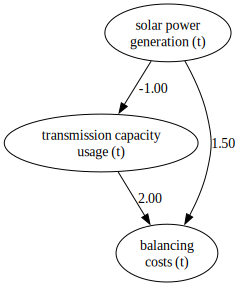

In [3]:
labels_0 = ["solar power \ngeneration (t)", "transmission capacity \nusage (t)", "balancing \ncosts (t)"]
make_dot(B0, labels=labels_0)

## Lagged effects

Given the time-dependent nature of the data, balancing costs at time $t$ are also dependent upon the solar generation and spare capacity observed at the previous time step. However, there are no lagged causal associations between solar generation and transmission capacity.

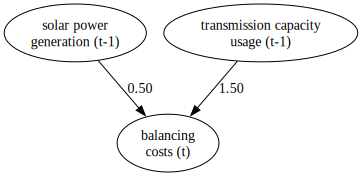

In [4]:
labels_1 = ["solar power \ngeneration (t-1)", "transmission capacity \nusage (t-1)", "balancing \ncosts (t)"]
make_dot(B1, labels=labels_1)

## Putting all together

We can now see the complete causal structure of the data-generating process, including both contemporaneous and lagged effects.

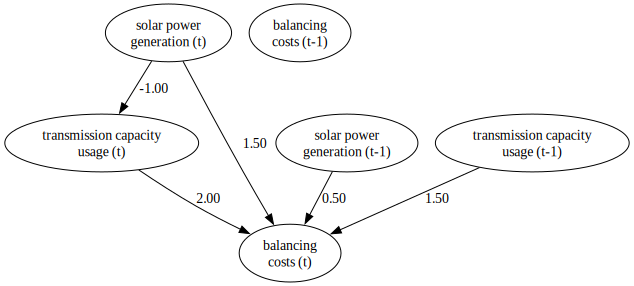

In [5]:
labels = ["solar power \ngeneration (t)", "transmission capacity \nusage (t)", "balancing \ncosts (t)",
         "solar power \ngeneration (t-1)", "transmission capacity \nusage (t-1)", "balancing \ncosts (t-1)"]
make_dot(np.hstack((B0, B1)), ignore_shape=True, lower_limit=0.05, labels=labels)

We will now **generate some observations** using the previous causal graph, and then try to retrieve the true causal structure using **VARLiNGAM**.

In [6]:
# Generating data according to this causal graph
B0 = np.array(B0)
B1 = np.array(B1)

# Sample size
n_features = len(causal_order)
sample_size = 1000

# Initialize the data matrix with zeros (considering t and t-1)
data = np.zeros((sample_size + 1, n_features))  # +1 to accommodate initial values at t=-1

# Add non-Gaussian noise for each variable and each time point
for i in range(n_features):
    data[:, i] += np.random.uniform(size=sample_size + 1)

# Generate data according to true causal graph
for t in range(1, sample_size + 1):
    for var in causal_order:
        data[t, var] += np.dot(B0[var, :], data[t, :]) + np.dot(B1[var, :], data[t-1, :])

# Drop the initial row used for t=-1 values
data = data[1:, :]

# Convert to DataFrame for easier handling
cols = ["solar power generation", "transmission capacity usage", "balancing costs"]
X = pd.DataFrame(data, columns=cols)

We can now plot the generated time series

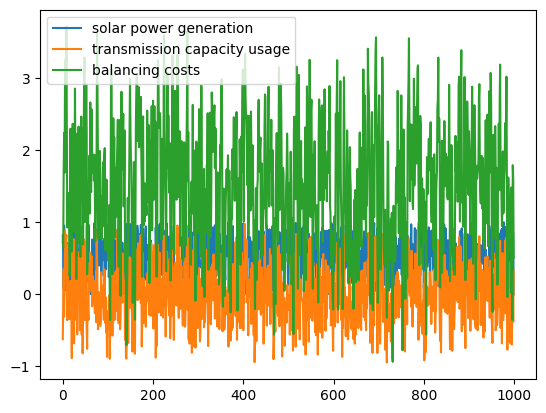

In [7]:
for i in range(X.shape[1]):
    plt.plot(X.index, X.iloc[:, i], label=cols[i])
plt.legend()

### Estimating contemporaneous effects

This process is relatively simple, and includes:
1. **Fitting a VAR model** to the time series, to get rid of autocorrelation and lagged effects.
2. Applying traditional **LiNGAM model to the residuals**.

This allows us to estimate the matrix of contemporaneous effects, $B_0$.


Here we fit a VAR model

In [8]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(X)
results = model.fit(1)  # Fit VAR(1)
residuals = results.resid

let's plot the residuals

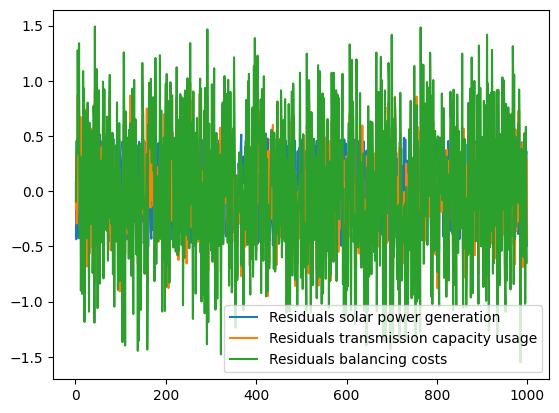

In [9]:
for i in range(residuals.shape[1]):
    plt.plot(residuals.index, residuals.iloc[:, i], label=f'Residuals {cols[i]}')
plt.legend()

Now, we can simply apply LiNGAM (as we did in the initial chapter) to the extracted residuals.

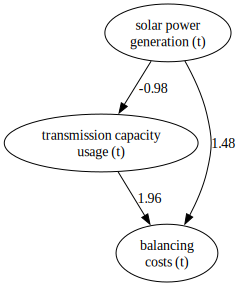

In [10]:
direct_model = lingam.DirectLiNGAM()
direct_model.fit(residuals)
make_dot(direct_model.adjacency_matrix_, labels=labels_0)

We can see how we got extremely close to the true contemporaneous effects.

### Estimating lagged effects

We can now estimate the matrix of lagged effects, $B_1$. The process (included in the VARLiNGAM method) involves correcting the matrix estimated by the VAR model to take into account the effects already considered in $B_0$.

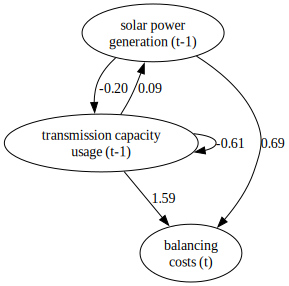

In [11]:
model = lingam.VARLiNGAM(lags=1)
model.fit(X)
make_dot(model.adjacency_matrices_[1], labels=labels_1) # B1

Unfortunately, this time the causal graph is not precisely equal to the true one for the lagged effects. However, the largest lagged effects (transmission capacity and solar generation on balancing costs) have been properly identified, with the correct magnitude and sign.

### Complete causal graph

We can now create the complete causal structure by simply stacking the two coefficient matrices $B_0$ and $B_1$.

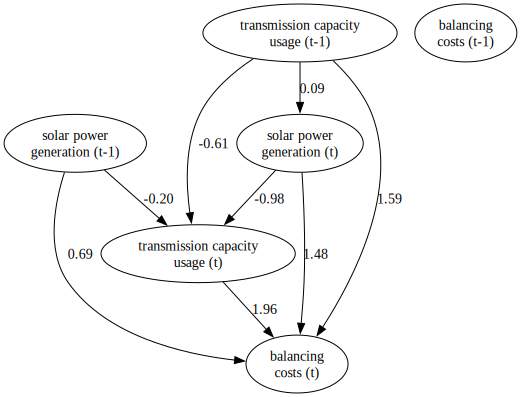

In [12]:
# Combined estimated graph
make_dot(np.hstack([direct_model.adjacency_matrix_, model.adjacency_matrices_[1]]), ignore_shape=True, lower_limit=0.05, labels=labels)